<div style="float:left">
    <h1 style="width:450px">Practical 8: </h1>
    <h2 style="width:450px">Visualisation and Linked Data</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Practial-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Task 1. Find London MSOAs

#### Grab E+W MSOA Shapefile

This -- and a lot of other data besides! -- can be accessed from the [GeoPortal](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-ew-bgc-v2). And see also my discussion on [lookup tables](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales).

<AxesSubplot:>

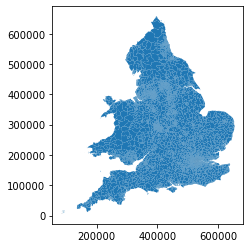

In [2]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [3]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
6240,6241,E02006379,Reigate and Banstead 005,Reigate and Banstead 005,523146,157530,-0.23482,51.30357,1.434404e+06,6894.516764,"POLYGON ((522673.410 157890.920, 522720.675 15..."
3665,3666,E02003759,Huntingdonshire 007,Huntingdonshire 007,535103,273965,-0.01799,52.34713,2.567444e+07,29790.999295,"MULTIPOLYGON (((538480.525 274695.871, 538381...."
5955,5956,E02006092,South Somerset 018,South Somerset 018,353992,115404,-2.65612,50.93622,3.656909e+06,14468.568120,"POLYGON ((352253.415 116504.718, 352271.741 11..."


#### Grab the Borough Boundaries

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

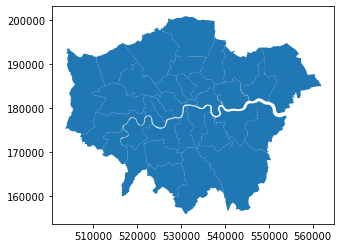

In [4]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
boros.plot()

We can then generate the boundary for London using the `unary_union` operator (as we do here) or using the earlier [`dissolve(by=region)`](https://geopandas.org/aggregation_with_dissolve.html) approach. Consider the pros and cons of each approach in terms of performance, output format, and legibility. 

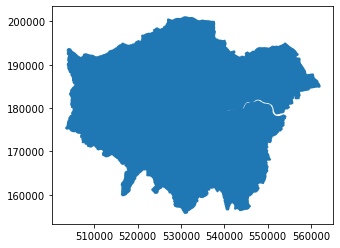

In [5]:
#ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
# In order to ensure that we get all MSOAs _within_ London 
# we will buffer the boundary by 250m. If _cover_ were 
# easier to use then that option might be preferable.
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

#### Task 1.1: Select London MSOAs using a Spatial Join

Here's our first spatial join. By default it will be an _inner_ join.

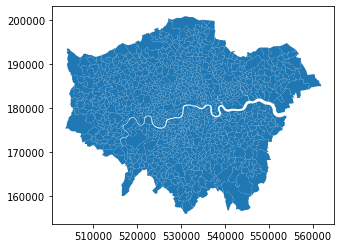

In [6]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

We no longer really need to keep the full MSOA data set hanging about.

In [7]:
del(msoas)

#### Task 1.2: Extract Borough Names

Notice that the MSOA Name _contains_ the Borough name. Use a regex (in `str.replace()`) to extract the LA name from the MSOA name.

In [8]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r'\s\d+$','',regex=True)

# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 14
print(ldn_msoas.Borough.unique())
print(len(ldn_msoas.Borough.unique()))
print(ldn_msoas.shape)

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
33
(983, 14)


#### Task 1.3: Add MSOA Names using a Merge

The House of Commons Library provides a [MSOA Names](https://visual.parliament.uk/msoanames) data set that contains locally-relevant names applied to MSOAs. These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [9]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [10]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02005951,Oxford 012,Oxford 012,Grandpont & New Hinksey,NaN,Oxford
4660,W02000113,Powys 017,Powys 017,Brecon,Aberhonddu,Powys
1038,W02000309,Caerphilly 020,Caerffili 020,Bedwas & Trethomas,Bedwas a Thretomas,Caerphilly


In [11]:
print(ldn_msoas.columns)
print(msoa_nms.columns)

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry', 'index_right',
       'original', 'Borough'],
      dtype='object')
Index(['msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm', 'msoa11hclnmw',
       'Laname'],
      dtype='object')


Now that you've loaded the `msoa_nms` data you need to merge it with our `ldn_msoas`. You will need to deal with the fact that the left and right fields have different names and may also want to think about the `how` of the merge.

In [12]:
msoas = pd.merge(ldn_msoas, msoa_nms, how = 'left', left_on = 'MSOA11CD', right_on = 'msoa11cd')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(983, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
810,811,E02000841,Sutton 002,St Helier South
801,802,E02000832,Southwark 026,Nunhead North
813,814,E02000844,Sutton 005,The Wrythe


Your result should be:

|    | OBJECTID | MSOA11CD | MSOA11NM | msoa11hclnm |
| -: | -------: | -------: | :------- | :---------- |
| **810** | 811 | E02000841 | Sutton 002 | St Helier South |
| **801** | 802 | E02000832 | Southwark 026 | Nunhead North |
| **813** | 814 | E02000844 | Sutton 005 | The Wrythe |

#### Tidy Up

In [13]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(983, 8)


#### And Save

In [14]:
msoas.to_file(os.path.join('data','geo','London_MSOAs.gpkg'), driver='GPKG')

## Task 2. Load InsideAirbnb Data

Load the InsideAirbnb data into a DataFrame.

In [15]:
cols = ['id','name','price','latitude','longitude','property_type','room_type']
df = pd.read_csv(os.path.join("data","raw", "2020-08-24-listings.csv.gz"), usecols=cols, low_memory=False)

Clean the data:

In [28]:
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

/tmp/ipykernel_883/2874290354.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


(74184, 8)


#### Task 2.1: Add Geometry and Reproject

Convert the df into a GeoDataFrame named gdf:

In [29]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

#### Task 2.2: Add LA Names to Data

Associate LA (Local Authority) names to the listings using a spatial join:

In [30]:
gdf_la = gpd.sjoin(gdf, boros, how = 'left', op='within')
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'property_type' 'room_type' 'price'
 'geometry' 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA'
 'ONS_INNER']


In [31]:
print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

(74184, 14)


,id,name,NAME
66121,41808059.0,"Haverstock Hotel, Twin Room",Camden
58701,38685213.0,Charming 1st floor two bedroom Fulham apartment,Hammersmith and Fulham
53195,35724891.0,Lovely East End En-Suite Room in Great Location.,Tower Hamlets


You should have a GeoDataFrame with 74,184 rows and 15 columns and the following tabular output:

|       | id | name | NAME |
| ----: | -------: | :---------- | :---------- |
| 66121 | 41808059 | Haverstock Hotel, Twin Room | Camden |
| 58701 | 38685213 | Charming 1st floor two bedroom Fulham apartment| Hammersmith and Fulham |
| 53195 | 35724891 | Lovely East End En-Suite Room in Great Location. | Tower Hamlets |

#### Task 2.3: Tidy Up

In [32]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Lambeth', 'Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Hackney', 'Southwark',
       'Croydon', 'Tower Hamlets', 'Waltham Forest', 'Brent', 'Camden',
       'Newham', 'Redbridge', 'Merton', 'Lewisham', 'Wandsworth',
       'Bromley', 'Havering', 'Greenwich', 'Ealing', 'Enfield',
       'City of London', 'Barking and Dagenham', 'Hillingdon', 'Harrow',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

There's something strange about the output of `unique()` above... can you spot it? There are 15 problematic records... see if you can print them out here:

In [33]:
gdf_la[gdf_la['NAME'].isnull()][['id','name']]

,id,name
24473,18841368.0,"Luxury Double Room, King Size Bed near to 02 A..."
38487,26648789.0,London Riverview Flat - Excel and City Airport
70689,43596360.0,Modern river view apartment near the centre
70824,43685598.0,Thames view apartment in Battersea
70891,43724271.0,Close to the river - a private space
70954,43755065.0,Cosy friendly house set in a peaceful environm...
71192,43885927.0,Rochester Way Apartment 5
71216,43894894.0,Greenwich Home with a View
72172,44211247.0,Luxury room in shared 2 bed waterfront apartment
72350,44273549.0,Exclusive Bright Studio - Central London


#### Task 2.4: Map Problematic Listings

Now see if you can map them as below:

<AxesSubplot:>

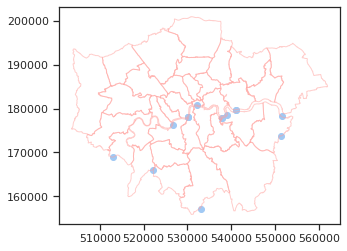

In [34]:
ax = gdf_la[gdf_la['NAME'].isnull()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

Your result should be:

![](https://github.com/jreades/i2p/blob/master/lectures/img/Unmatched_Listings.png?raw=true)

#### Task 2.5: Drop Problematic Results

In [35]:
gdf_la.drop(index=gdf_la[gdf_la['NAME'].isnull()].index, axis=1, inplace=True)
print(gdf_la.shape)

(74169, 10)


You should now have 74,169 records.

#### Task 2.6: Check Results

<AxesSubplot:>

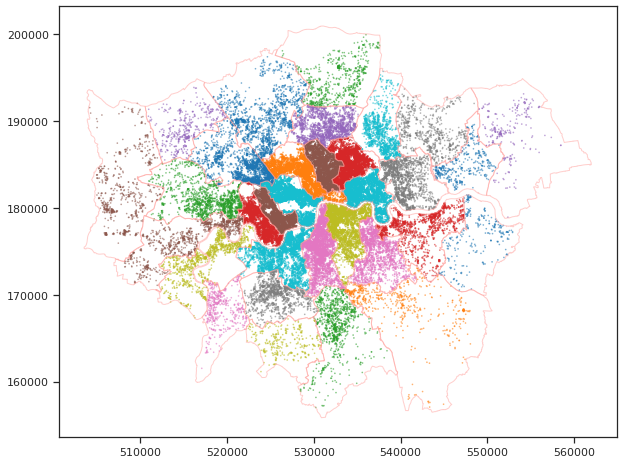

In [36]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

## Task 3. Using Seaborn and Grouped Data

#### Task 3.1: A Basic Boxplot

See if you can create a basic boxplot of price by room type, and then set the y-limits to 0-500 (£/night).

[(0.0, 500.0)]

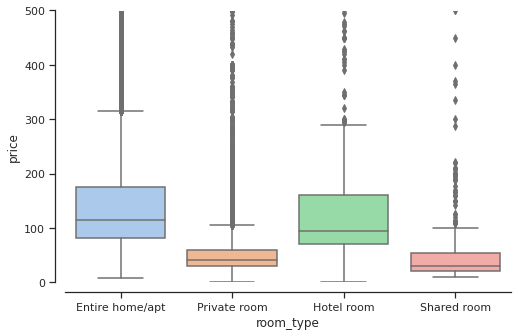

In [37]:
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(x='room_type', y='price', data=gdf_la)
sns.despine(offset=10)
ax.set(ylim=[0,500])

#### Task 3.2: Grouping on One Column

Let's group the data on the LA name. You should get that the type is a `DataFrameGroupBy`.

In [38]:
la_data = gdf_la.groupby('NAME')
print(type(la_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


Notice the result here:

In [40]:
la_data.price.mean()

NAME
Barking and Dagenham       59.246719
Barnet                     89.803606
Bexley                     65.969697
Brent                     100.320199
Bromley                    71.495409
Camden                    134.644442
City of London            209.521220
Croydon                    58.140643
Ealing                    100.247022
Enfield                    76.418049
Greenwich                  99.666963
Hackney                    89.672230
Hammersmith and Fulham    130.214894
Haringey                   92.239021
Harrow                     79.084567
Havering                   67.882591
Hillingdon                 60.451494
Hounslow                   97.180144
Islington                 120.629270
Kensington and Chelsea    191.254569
Kingston upon Thames       85.334470
Lambeth                    94.889265
Lewisham                   82.352265
Merton                    111.460489
Newham                     83.756255
Redbridge                  80.051494
Richmond upon Thames      125.371

#### Task 3.3: A Basic Distribution Plot

Although this is hardly the most robust analysis (subtracting the mean of a grouped mean from a grouped mean seems... sketchy), it's useful for quickly demonstrating a different plot type and then asking you to work out how to obtain something close to the output below using these solutions:

- [Figure title](https://matplotlib.org/3.3.3/gallery/subplots_axes_and_figures/figure_title.html)
- [How to position `suptitle`](https://stackoverflow.com/questions/55767312/how-to-position-suptitle)
- [Label axes on Seaborn Barplot](https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot)

Text(0.5, 0.98, 'Standardised Mean Price')

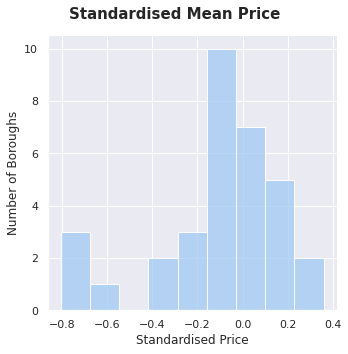

In [58]:
sns.set_style('darkgrid')
ax = sns.displot((la_data.price.mean() - la_data.price.mean().mean())/la_data.price.std())
ax.set(xlabel = 'Standardised Price', ylabel = 'Number of Boroughs')
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().suptitle('Standardised Mean Price', fontsize = 15, fontweight = 'bold')

Your result should be close to:

![](https://github.com/jreades/i2p/blob/master/lectures/img/std_boro_price.png?raw=true)

#### Task 3.4: Grouping on Multiple Columns

We're now going to create a data frame grouped by LA and room type, and then use the `agg` (aggregate) function on a grouped data frame and derive several measures (Count, Sum, Mean, Median, std, Lower Quartile, and Upper Quartile) in one go from the price column. 

You will want to search on something like "Multiple aggregations of the same column using pandas GroupBy.agg()" in order to work this out. 

You'll also need to look at "calculate quantile pandas aggregate" -- depending on the solution you choose, your quantiles may or may not have the same labels as mine below.

In [59]:
def q25(x):
    return x.quantile(0.25)
# 90th Percentile
def q75(x):
    return x.quantile(0.75)
#la_data2 = gdf_la.groupby(['NAME', 'room_type']).agg({"price": [np.count_nonzero, np.sum, np.mean, np.median, np.std, q25, q75]}).reset_index()

la_data2 = gdf_la.groupby(['NAME', 'room_type']).agg({"price": [np.count_nonzero, np.sum, np.mean, np.median, np.std, lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]}).reset_index()


In [60]:
la_data2.sample(3, random_state=42)

NAME        room_type         price                               \
                               count_nonzero       sum        mean median   
18    Bromley     Private room           334  17288.86   51.763054   36.0   
42  Greenwich     Private room           830  62005.70   74.705663   38.0   
36    Enfield  Entire home/apt           217  26437.72  121.832811   95.0   

                                      
           std <lambda_0> <lambda_1>  
18   91.390795       27.0      50.00  
42  223.600981       28.0      53.75  
36  121.763967       70.0     130.00

My sample gives me:

|    | NAME | room_type |     |     |     |     |     |     | price |
| -: | :--- | :-------- | --: | --: | --: | --: | --: | --: | ----: |
|    |      |           | **count** | **sum** | **mean** | **median** | **std** | **\<lambda_0\>** | **\<lambda_1\>** |
| 18 | Bromley | Private room | 334 | 17288.86 | 51.763054 | 36.0 | 91.390795 | 27.0 | 50.00 |
| 42 | Greenwich | Private room | 830 | 62005.70 | 74.705663 | 38.0 | 223.600981 | 28.0 | 53.75 |
| 36 | Enfield | Entire home/apt | 217 | 26437.72 | 121.832811 | 95.0 | 121.763967 | 70.0 | 130.00 |

I am _not_ cruel enough to make you work out how to convert the above to a flat index, so here's the code to do that:

In [61]:
la_data2.columns = la_data2.columns.droplevel(0)
print(la_data2.columns.values)

['' '' 'count_nonzero' 'sum' 'mean' 'median' 'std' '<lambda_0>'
 '<lambda_1>']


So now we just need to correct a few column labels manually:

In [62]:
cols = la_data2.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data2.columns = cols

This next plot may take a while to run:

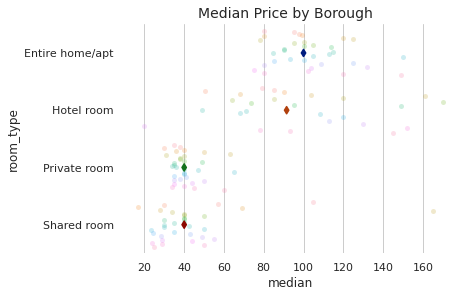

In [63]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="name",
              data=la_data2, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data2.groupby('room_type').agg('median').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Median Price by Borough', fontsize=14);

#### Task 3.5: Grouping on a Custom Mapping

Use the map below, taken from the Centre for London's [_Housing and Inequality in London_](https://www.centreforlondon.org/wp-content/uploads/2016/08/CFLJ4292-London-Inequality-04_16_WEB_V4.pdf) (p.17) to assign each LA to one of the five regions shown. Create a grouped data frame using this mapping instead of the LA one. Do so _without_ creating a new column.

![](https://github.com/jreades/i2p/blob/master/lectures/img/Borough_Mapping.png?raw=true)

Set up a `mapping` dict here so that you can apply it as part of the `groupby` operation below (you should have 33 keys when done):

In [ ]:
#Manually write...
#mapping = {}
#for b in ['Enfield', 'Waltham Forest', 'Redbridge', 'Barking']:
#    mapping[b]='Outer East and North East'
#print(len(mapping.keys()))

Group by your mapping and by `room_type`, and calculate the mean and median price only:

In [ ]:
la_data3 = gdf_la.set_index('NAME').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()

In [ ]:
la_data3.sample(3, random_state=42)

My output looks like this:

|     | level_0 | room_type |     | price |
| --: | :------ | :-------- | --: | ----: |
|     |         |           | **mean** | **median** |
| 0 | Inner East | Entire home/apt | 138.428470 | 100.0 |
| 17 | Outer West and North West | Hotel room | 123.295429 | 85.0 |
| 15 | Outer South | Shared room | 57.0000000 | 45.0 |

In [ ]:
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

In [ ]:
la_data3.head(3)

See if you can produce the same plot as above but for the aggregated areas:

In [ ]:
sns.set_theme(style="whitegrid")


## Task 4. Exploring an LA using Subplots

Select a LA that is relevant to _you_ to explore further...

In [67]:
LA = 'Waltham Forest'

#### Task 4.1: Spatial Join Listings and MSOAs

The first thing we want to do is join MSOA identifiers in `msoas` to each listing in `gdf_la`. In both cases we want to constrain the data to only be for 'our' LA of interest. You do not have to save this to a new variable and can do the selection _as part_ of the spatial join:

In [78]:
msoadf  = gpd.sjoin(
            gdf_la[gdf_la["NAME"]==LA].reset_index(),
            msoas[msoas.Borough==LA], 
            op='within')

In [79]:
msoadf

,index,id,name,latitude,longitude,property_type,room_type,price,geometry,NAME,GSS_CODE,index_right,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,Borough,msoa11hclnm
0,23,41870.0,Room in relaxed family house!,51.55842,0.00382,Private room in house,Private room,37.0,POINT (539007.069 186295.481),Waltham Forest,E09000031,888,889,E02000921,Waltham Forest 027,538889,186133,Waltham Forest,Leytonstone South West
6,319,304976.0,Large House with 5 Double Bedrooms,51.55539,-0.00191,Entire house,Entire home/apt,221.0,POINT (538619.091 185947.670),Waltham Forest,E09000031,888,889,E02000921,Waltham Forest 027,538889,186133,Waltham Forest,Leytonstone South West
37,1085,588026.0,Great Olympic Room in Leytonstone *,51.56294,0.00608,Private room in house,Private room,135.0,POINT (539149.935 186802.410),Waltham Forest,E09000031,888,889,E02000921,Waltham Forest 027,538889,186133,Waltham Forest,Leytonstone South West
59,1733,1042006.0,Excellent room BLACK and WHITE,51.55533,-0.00029,Private room in house,Private room,105.0,POINT (538731.574 185944.068),Waltham Forest,E09000031,888,889,E02000921,Waltham Forest 027,538889,186133,Waltham Forest,Leytonstone South West
60,1766,1073554.0,20 min Central London EN SUITE BLUE,51.55605,0.00116,Private room in house,Private room,115.0,POINT (538829.898 186026.883),Waltham Forest,E09000031,888,889,E02000921,Waltham Forest 027,538889,186133,Waltham Forest,Leytonstone South West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,57011,37840525.0,Lovely Double bedroom + Bathroom in East London,51.63444,-0.00797,Private room in bungalow,Private room,50.0,POINT (537959.441 194726.818),Waltham Forest,E09000031,862,863,E02000895,Waltham Forest 001,537936,194880,Waltham Forest,Chingford Green West
1121,59280,38972972.0,"a lovely quiet home, welcoming short stay guests.",51.63972,-0.01168,Private room in bed and breakfast,Private room,35.0,POINT (537686.725 195306.981),Waltham Forest,E09000031,862,863,E02000895,Waltham Forest 001,537936,194880,Waltham Forest,Chingford Green West
1241,66228,41851726.0,Great home with exclusive access to Epping Forest,51.64330,-0.00695,Private room in house,Private room,50.0,POINT (538003.145 195714.009),Waltham Forest,E09000031,862,863,E02000895,Waltham Forest 001,537936,194880,Waltham Forest,Chingford Green West
1330,72611,44371989.0,Homely double in East London-relaxed getaway,51.63215,-0.00208,Private room in house,Private room,39.0,POINT (538373.997 194483.292),Waltham Forest,E09000031,862,863,E02000895,Waltham Forest 001,537936,194880,Waltham Forest,Chingford Green West


#### Task 4.2: Aggregate by MSOA

Now aggregate the data by MSOA, deriving median price and a count of the listings:

In [91]:
msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()

Which level value is easier to use? 0? or 1?

In [92]:
msoagrdf.columns = msoagrdf.columns.get_level_values(1)
msoagrdf.head()

,,median,count
0,Waltham Forest 001,51.0,14
1,Waltham Forest 002,55.0,19
2,Waltham Forest 003,50.0,7
3,Waltham Forest 004,45.0,9
4,Waltham Forest 005,29.0,11


Fix the missing column name:

In [93]:
msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

#### Task 4.3: Join on Indexes

Here we see the difference between merge and join. You'll notice that `join` operates taking one data frame as the implicit 'left' table (the one which _calls_ join) while the one that is passed to the join function is, implicitly, the 'right' table. Join operates only using indexes, so you'll need to insert the code to specify the same index on both data frames, but this can be done **on-the-fly** as part of the joining operation:

In [94]:
msoa_gdf = msoagrdf.set_index("MSOA11NM").join(
                msoas[msoas.Borough ==LA].set_index("MSOA11NM"), 
                rsuffix='_r')
msoa_gdf.head(3)

,median,listings,OBJECTID,MSOA11CD,BNG_E,BNG_N,geometry,Borough,msoa11hclnm
MSOA11NM,,,,,,,,,
Waltham Forest 001,51.0,14,863,E02000895,537936,194880,"POLYGON ((537919.442 195742.428, 538051.250 19...",Waltham Forest,Chingford Green West
Waltham Forest 002,55.0,19,864,E02000896,539350,194516,"POLYGON ((539172.688 195540.000, 539696.813 19...",Waltham Forest,Chingford Green East
Waltham Forest 003,50.0,7,865,E02000897,539355,193522,"POLYGON ((538862.624 194017.438, 539001.125 19...",Waltham Forest,Friday Hill


You need to add a command in order to help python recognise that this should be a GeoDataFrame:

In [ ]:
#msoa_gdf["geometry"]...

AttributeError: 'Line2D' object has no property 'column'

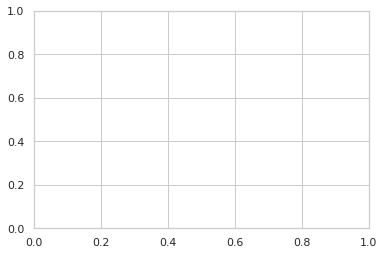

In [95]:
msoa_gdf.plot(column='median', legend=True)

#### Task 4.4: Discover Fonts Installed

I find matplotlib's use of fonts to be _profoundly_ weird. Basically, you need to investigate the 'font cache' folder and see what's listed there. Depending on how you installed the Python libraries you _might_ have access to your whole computer's fonts (if you used `conda`) or to only those free fonts that come with Linux (if you used Vagrant or Docker). This code may not even run on a PC or Mac with `conda` in which case you'll need to do some more investigating and poking around...

In [ ]:
import matplotlib
loc = matplotlib.get_cachedir()
!ls {loc}

Hopefully you will see a list of installed fonts when you run this. See if you can make sense of what this code does!

In [ ]:
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
print(fonts)

I am setting this as the 'title font' (`tfont`) to use in the output below. You can pick another font and see what happens. The format for this is a dictionary, so where you see `fontdict` in the `matplotlib` documentation this should work:

In [ ]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

#### 4.5: Create at Atlas-Type Output

We're now going to emulate a _bit_ of QGIS' Atlas function by creating two subplots and then adding a _third_ plot afterwards that shows where the borough is.

In [ ]:
f,axes = plt.subplots(1,2,figsize=(12,8))

#median using 1st axis, listings using 2nd axis
msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')

#For the small overall London plot... [height, width, x position, y position]
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
#highlighting Waltham Forest
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2) 
ax2.axis('off')

#Creating subplot titles
f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)
#Figure text showing the number of listings considered
plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

#### Bonus Achievement Unlocked!

See if you can convert the above to an _actual_ atlas output: you'll want to turn this into a function so as to be able to produce (and save) the map for _every_ borough. You'll even need to parameterise the filename so that you save to _different_ PNG files...

## Task 5. Using Bokeh

#### Task 5.1: For a Chart

Group the listings by Borough and Room Type, and aggregate by median price, also producing a count variable for the number of listings of each type in each Borough.

In [96]:
la_rt = gdf_la.groupby(['NAME','room_type']).agg({'price':['median', 'count']}).reset_index()
la_rt.columns = ['NAME','room_type','price','listings']
la_rt.head()

,NAME,room_type,price,listings
0,Barking and Dagenham,Entire home/apt,80.0,105
1,Barking and Dagenham,Hotel room,79.0,1
2,Barking and Dagenham,Private room,35.0,271
3,Barking and Dagenham,Shared room,105.0,4
4,Barnet,Entire home/apt,95.0,662


Choose a LA of interest:

In [97]:
LA = 'Camden'

In [98]:
la_rt[la_rt.NAME==LA]

,NAME,room_type,price,listings
20,Camden,Entire home/apt,120.0,3423
21,Camden,Hotel room,104.0,48
22,Camden,Private room,50.0,1667
23,Camden,Shared room,28.0,33


In [99]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import CustomJS, Dropdown

output_notebook()

room_types = list(la_rt[la_rt.NAME==LA].room_type.values)
price = list(la_rt[la_rt.NAME==LA].price.values)
boros = list(la_rt[la_rt.NAME==LA].NAME.values)
counts = list(la_rt[la_rt.NAME==LA].listings.values)

#adjusting data type for Bokeh
source = ColumnDataSource(data=dict(
                                room_types=room_types, 
                                price=price, 
                                counts=counts, 
                                boros=boros, 
                                color=Spectral4))

#create figure
p = figure(x_range=room_types, plot_height=300, title=f"Median Price by Room Type in {LA}",
           toolbar_location=None, tools="")

p.vbar(x='room_types', top='price', width=0.9, color='color', legend_field="room_types", source=source)

p.xgrid.grid_line_color = None
p.y_range.start = 0

# Add hover
p.add_tools(
    HoverTool(tooltips = [("Borough", "@boros"),
                          ("Listings", "@counts"),
                          ("Median Price", "$@price/night")]
             )
)

show(p)

Loading BokehJS ...

#### Task 5.2: For a Map

This is not the prettiest code, but it should work...

In [100]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

from bokeh.io import output_file, show, output_notebook, push_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

I cobbled the mapping functions below together from two tutorials I found online ([this one](https://github.com/dmnfarrell/teaching/blob/master/geo/maps_python.ipynb) and [this one](https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/interactive_bokeh_map/interactive_bokeh_map.html)). As you can see, this is a very different approach to mapping data, but it has clear benefits for exploratory purposes and produces fast, interactive maps... and I've not even added selection and filtering tools!

In [101]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """
    
    tile_provider = get_provider(CARTODBPOSITRON)

    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette=palette, low=vals.min(), high=vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=10,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset,hover'
    
    p = figure(title = title, plot_height=700, plot_width=850, toolbar_location='right', tools=tools)
    p.add_tile(tile_provider)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=0.5, line_width=0.5, line_color='white',  
              fill_color={'field' :column , 'transform': color_mapper})
    
    # Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    # Add hover
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [("Borough", "@Borough"),
                      ("Name", "@msoa11hclnm"),
                      ("Listings", "@listings"),
                      ("Median Price", "£@price")]
    
    return p

First, spatially join individual listings to MSOAs. You will need to think about the `how` here!

In [102]:
msoadf  = gpd.sjoin(gdf_la, msoas, how='right', op='within')
msoadf.sample(3, random_state=42)

,index_left,id,name,latitude,longitude,property_type,room_type,price,NAME,GSS_CODE,OBJECTID,MSOA11CD,MSOA11NM,BNG_E,BNG_N,geometry,Borough,msoa11hclnm
934,36686.0,25372717.0,Amber Studios London near Marble Arch,51.51901,-0.15808,Entire serviced apartment,Entire home/apt,165.0,Westminster,E09000033,935,E02000967,Westminster 008,527932,182291,"POLYGON ((527868.959 183051.236, 527821.222 18...",Westminster,Regent's Park
856,62641.0,40343292.0,Double Room close to Tower Hill,51.51079,-0.05479,Private room in apartment,Private room,45.0,Tower Hamlets,E09000030,857,E02000888,Tower Hamlets 025,535978,180876,"POLYGON ((536352.045 181123.953, 536332.986 18...",Tower Hamlets,Shadwell Basin & Ratcliffe
609,57403.0,38032709.0,Private room 5 minute from kings college hospital,51.46828,-0.10115,Private room in apartment,Private room,35.0,Lambeth,E09000022,610,E02000631,Lambeth 014,532316,175516,"POLYGON ((532555.915 176357.131, 532603.042 17...",Lambeth,Herne Hill East


Then group by and aggregate based on median price and count. Notice how the output from this differs subtly from what you'd get with `{'price':['median','count']}`!

In [103]:
msoagrdf2 = msoadf.groupby('MSOA11NM').agg({'price':['median'],'room_type':['count']}).reset_index()
msoagrdf2.head()

,MSOA11NM,price,room_type
,,median,count
0,Barking and Dagenham 001,50.0,10
1,Barking and Dagenham 002,40.0,24
2,Barking and Dagenham 003,29.0,1
3,Barking and Dagenham 004,69.0,12
4,Barking and Dagenham 006,48.0,19


Reset the levels and fix the column names:

In [104]:
msoagrdf2.columns = msoagrdf2.columns.get_level_values(0)
msoagrdf2.rename(columns={'room_type':'listings'}, inplace=True)
msoagrdf2.head()

,MSOA11NM,price,listings
0,Barking and Dagenham 001,50.0,10
1,Barking and Dagenham 002,40.0,24
2,Barking and Dagenham 003,29.0,1
3,Barking and Dagenham 004,69.0,12
4,Barking and Dagenham 006,48.0,19


Check the data range(s) and resolve any apparent issues:

In [105]:
msoagrdf2.sort_values(by='price', ascending=False).head(5)

,MSOA11NM,price,listings
336,Greenwich 030,1880.00,22
977,Westminster 019,250.00,238
588,Kensington and Chelsea 012,212.00,368
969,Westminster 011,187.57,463
976,Westminster 018,171.00,899


In [ ]:
msoagrdf2.loc[??,??] = np.nan

Check the results of any modification:

In [ ]:
msoagrdf2.sort_values(by='price', ascending=False).head(5)

Read in the MSOA GPKG file that we saved earlier:

In [ ]:
msoas = gpd.read_file(os.path.join('data','geo','London_MSOAs.gpkg'))
msoageo = pd.merge(msoas, msoagrdf2, on='MSOA11NM')

Reproject to Web Mercator:

In [ ]:
msoageo = msoageo.to_crs('epsg:3785')
msoageo.total_bounds

And map it!

In [ ]:
p = bokeh_plot_map(msoageo, 'price', title='MSOA-Level Activity')

handle = show(p, notebook_handle=True)
push_notebook(handle=handle)